In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np


In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/焦炭港口价格.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['焦炭港口价格（准一级，日照）'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()


,现货焦化利润/港口模拟/即期,主焦煤价格/临汾,焦炭港口价格（准一级，日照）
2025-12-01,NaN,NaN,NaN
2025-12-02,NaN,NaN,NaN
2025-12-03,NaN,NaN,NaN
2025-12-04,NaN,NaN,NaN
2025-12-05,NaN,NaN,NaN


In [5]:
file_path1 = os.path.expanduser("eta/焦化厂利润_合并数据.xlsx") 
sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet1 = sheet1.drop(columns=['真实值'])
sheet1 = sheet1.dropna()

sheet1 = sheet1.sort_values('Date', ascending=True)
sheet1.tail()

,Date,预测值
4,2025-12-01,-144.5
3,2025-12-02,-157.8
2,2025-12-03,-170.2
1,2025-12-04,-168.4
0,2025-12-05,-160.2


In [6]:
# 尝试多个可能的文件路径
file_paths2 = [
    os.path.expanduser("~/Desktop/X-BASE/焦煤/eta/主焦煤价格-临汾_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/焦煤/eta/主焦煤价格-临汾_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/焦煤/eta/主焦煤价格-临汾_合并数据.xlsx")
]

file_path2 = None
for path in file_paths2:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path2 = path
        break

if file_path2 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet2 = pd.read_excel(file_path2, sheet_name='Sheet1')
    sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
    sheet2 = sheet2.drop(columns=['主焦煤价格/临汾'])
    sheet2 = sheet2.dropna()
    sheet2 = sheet2.sort_values('Date', ascending=True)
    sheet2.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")
sheet2.head()  

,Date,主焦煤价格/临汾_预测
4,2025-11-08,1660.000000
3,2025-11-14,1644.061550
2,2025-11-21,1559.473380
1,2025-11-28,1579.738776
0,2025-12-05,1576.338137


In [7]:
sheet.columns

Index(['现货焦化利润/港口模拟/即期', '主焦煤价格/临汾', '焦炭港口价格（准一级，日照）'], dtype='object')

In [8]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['现货焦化利润/港口模拟/即期'] = sheet_daily['现货焦化利润/港口模拟/即期'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', '主焦煤价格/临汾_预测']],
    on='Date',
    how='left'
)
sheet_daily['主焦煤价格/临汾'] = sheet_daily['主焦煤价格/临汾'].fillna(sheet_daily['主焦煤价格/临汾_预测'])
sheet_daily = sheet_daily.drop(columns=['主焦煤价格/临汾_预测'])


sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-06-01')]
sheet_daily.tail(10)

,Date,现货焦化利润/港口模拟/即期,主焦煤价格/临汾,焦炭港口价格（准一级，日照）
4059,2025-11-24,-113.1,NaN,NaN
4060,2025-11-25,-146.1,NaN,NaN
4061,2025-11-26,-150.1,NaN,NaN
4062,2025-11-27,-140.6,NaN,NaN
4063,2025-11-28,-139.4,1579.738776,NaN
4064,2025-12-01,-144.5,NaN,NaN
4065,2025-12-02,-157.8,NaN,NaN
4066,2025-12-03,-170.2,NaN,NaN
4067,2025-12-04,-168.4,NaN,NaN
4068,2025-12-05,-160.2,1576.338137,NaN


In [9]:
# 添加新列 山东汽油裂解差_预测
sheet_daily['焦炭港口价格（准一级，日照）_预测'] = (3.8)*sheet_daily['现货焦化利润/港口模拟/即期']  + sheet_daily['主焦煤价格/临汾']*(-1.3) +4200

# 线性填充焦炭港口价格（准一级，日照）_预测
sheet_daily['焦炭港口价格（准一级，日照）_预测'] = sheet_daily['焦炭港口价格（准一级，日照）_预测'].interpolate(method='linear')
sheet_daily.tail()

,Date,现货焦化利润/港口模拟/即期,主焦煤价格/临汾,焦炭港口价格（准一级，日照）,焦炭港口价格（准一级，日照）_预测
4064,2025-12-01,-144.5,NaN,NaN,1601.695757
4065,2025-12-02,-157.8,NaN,NaN,1586.771923
4066,2025-12-03,-170.2,NaN,NaN,1571.848090
4067,2025-12-04,-168.4,NaN,NaN,1556.924256
4068,2025-12-05,-160.2,1576.338137,NaN,1542.000422


In [10]:
last_day = sheet_daily['Date'][sheet_daily['焦炭港口价格（准一级，日照）'].last_valid_index()]

---

In [11]:
# 创建历史数据部分
historical = sheet_daily[sheet_daily['Date'] <= last_day][['Date', '焦炭港口价格（准一级，日照）']]
historical.columns = ['Date', '焦炭港口价格（准一级，日照）']

# 创建预测数据部分 
forecast = sheet_daily[sheet_daily['Date'] > last_day][['Date', '焦炭港口价格（准一级，日照）_预测']]
forecast.columns = ['Date', '焦炭港口价格（准一级，日照）_预测']

# 合并历史和预测数据
merged_df_daily = pd.concat([historical, forecast], axis=0, join='outer')
merged_df_daily = merged_df_daily.sort_values('Date').reset_index(drop=True)
merged_df_daily = merged_df_daily.sort_values(by='Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/焦炭港口价格（准一级，日照）_合并数据.xlsx', index=False,float_format='%.6f')
merged_df_daily.head()

,Date,焦炭港口价格（准一级，日照）,焦炭港口价格（准一级，日照）_预测
627,2025/12/05,NaN,1542.000422
626,2025/12/04,NaN,1556.924256
625,2025/12/03,NaN,1571.848090
624,2025/12/02,NaN,1586.771923
623,2025/12/01,NaN,1601.695757


In [12]:
# 创建历史数据部分
historical_monthly = sheet_daily[sheet_daily['Date'] <= last_day][['Date', '焦炭港口价格（准一级，日照）']]
historical_monthly.columns = ['Date', '焦炭港口价格（准一级，日照）']

# 创建预测数据部分 
forecast_monthly = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2024-10-01')][['Date', '焦炭港口价格（准一级，日照）_预测']]
forecast_monthly.columns = ['Date', '焦炭港口价格（准一级，日照）_预测']

merged_df_monthly = pd.merge(historical_monthly, forecast_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/焦炭港口价格（准一级，日照）_月度数据.xlsx', index=False,float_format= '%.4f')
merged_df_monthly.head()

,Date,焦炭港口价格（准一级，日照）,焦炭港口价格（准一级，日照）_预测
30,2025/12/31,NaN,1571.848090
29,2025/11/30,1568.000000,1509.736234
28,2025/10/31,1481.111111,1260.626924
27,2025/09/30,1450.434783,1538.030997
26,2025/08/31,1455.714286,1607.265164


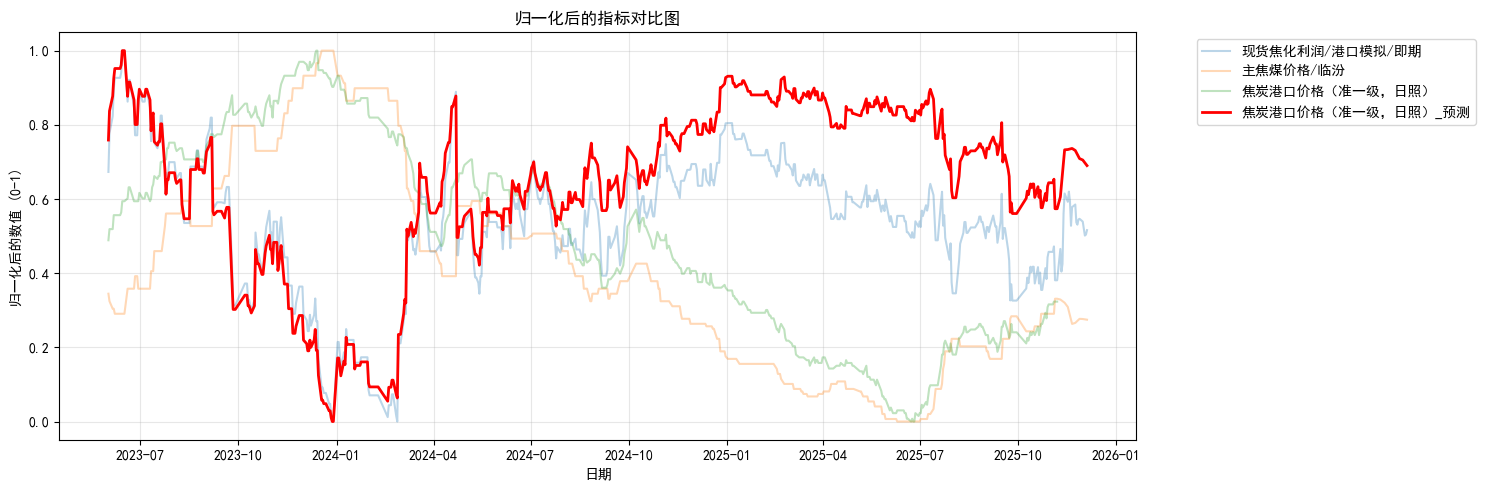

In [13]:
# 对数据进行归一化处理
from sklearn.preprocessing import MinMaxScaler

# 创建一个新的DataFrame来存储归一化后的数据
normalized_df = sheet_daily.copy()

# 对每一列进行归一化处理(除了Date列)
scaler = MinMaxScaler()
columns_to_normalize = [col for col in sheet_daily.columns if col != 'Date']
normalized_df[columns_to_normalize] = scaler.fit_transform(sheet_daily[columns_to_normalize])
# 对这三列进行线性填充
cols_to_fill = ['主焦煤价格/临汾']
normalized_df[cols_to_fill] = normalized_df[cols_to_fill].interpolate(method='linear')

# 绘制归一化后的数据
plt.figure(figsize=(15, 5))

# 设置透明度
alpha_others = 0.3  
alpha_main = 1.0    

# 绘制每个指标
for col in normalized_df.columns:
    if col != 'Date':  
        if col == '焦炭港口价格（准一级，日照）_预测':
            plt.plot(normalized_df['Date'], normalized_df[col], 
                    label=col, 
                    color='red', 
                    linewidth=2,
                    alpha=alpha_main)
        else:
            plt.plot(normalized_df['Date'], normalized_df[col], 
                    label=col, 
                    alpha=alpha_others)

plt.title('归一化后的指标对比图')
plt.xlabel('日期')
plt.ylabel('归一化后的数值 (0-1)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



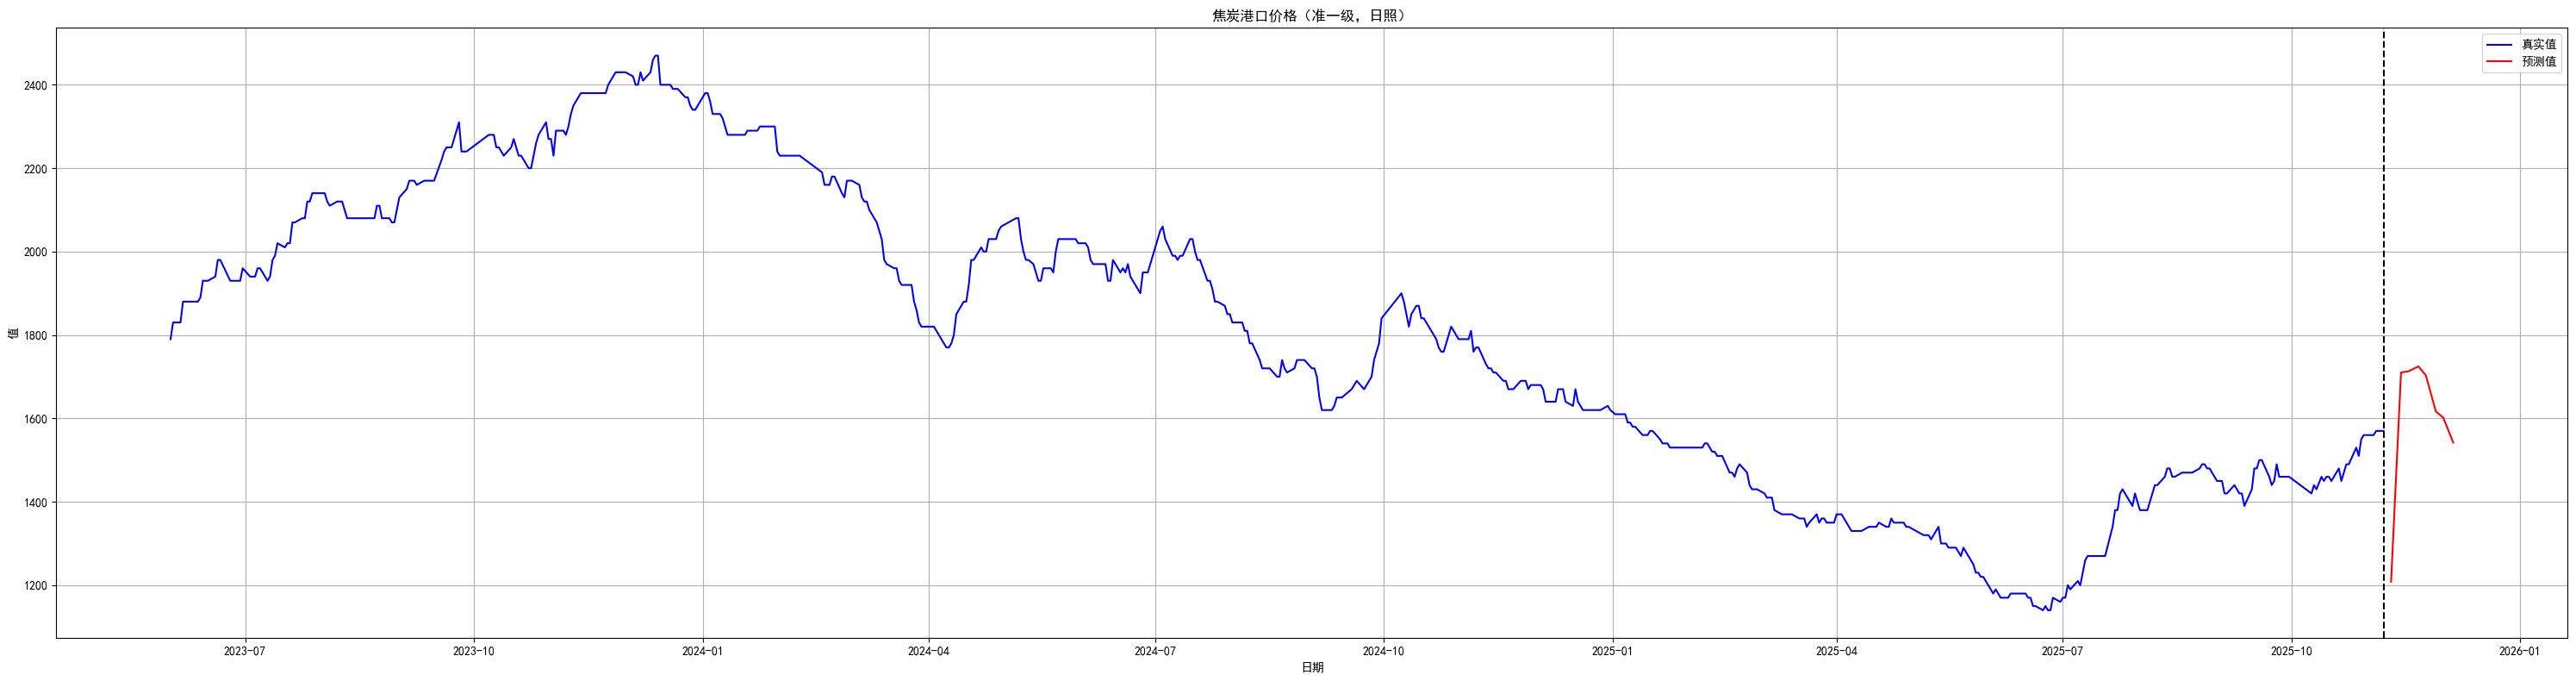

In [14]:
# 设置图形大小
plt.figure(figsize=(30, 8))

merged_df_daily_plot = merged_df_daily.copy()
merged_df_daily_plot['Date'] = pd.to_datetime(merged_df_daily_plot['Date'])

# 绘制真实值曲线(蓝色)
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['焦炭港口价格（准一级，日照）'], color='blue', label='真实值')
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['焦炭港口价格（准一级，日照）_预测'], color='red', label='预测值')

avline_date = pd.to_datetime(last_day)
plt.axvline(x=avline_date, color='black', linestyle='--')

# 设置图例
plt.legend()

# 设置标题和标签
plt.title('焦炭港口价格（准一级，日照）')
plt.xlabel('日期')
plt.ylabel('值')
plt.grid(True)
plt.tight_layout()
plt.show()

---

In [15]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.焦炭_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "焦炭港口价格"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [16]:
from Lcel import update_excel_data
file_path = "eta/1.焦炭_数据上传.xlsx"
sheet_name = "详情页"
identifier = "焦炭港口价格"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
